In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import copy
import random
import math
from typing import Tuple

In [2]:
# Visualization of gene activity, energy, and cell count
def plot_gene_dynamics(
    df,
    title="Genetic Dynamics",
    genes=None,
    energy=True,
    cell_count=True,
    cell_count_labels=True
):
    """
    Visualizes the dynamics of gene expression, energy, and cell count.

    Special mode: if genes == {} and energy == True and cell_count == True, then:
      1) Black line: CellCount (log → scaled so that max = 2× max(Energy)),
         with annotations of local extrema;
      2) Overlaid area plot of Energy (alpha=0.5);
      3) Right y-axis: secondary axis showing raw (non-scaled) CellCount.

    In normal mode: behaves as a standard visualization of gene dynamics.
    """
    if genes is None:
        genes = {
            "ENGSENS": "blue",
            "FOODSENS": "red",
            "HARVEST": "green",
            "DIVISION": "purple"
        }

    # Max expression level across selected genes (used for scaling)
    max_expr = 0.0
    for g in genes:
        if g in df.columns:
            max_expr = max(max_expr, df[g].max())

    fig, ax = plt.subplots(figsize=(12, 6))

    # ——— Спец-режим ———
    if energy and cell_count and len(genes) == 0:
        # ► 1) Black CellCount line (zorder=2)
        if "CellCount" in df.columns:
            log_cc = np.log(df["CellCount"].replace(0, np.nan)).fillna(0)
            max_log_cc = log_cc.max()
            max_e = df["Energy"].max() if "Energy" in df.columns else 0
            scale_cc = 0 if max_log_cc == 0 else 2 * max_e / max_log_cc
            cc_scaled = log_cc * scale_cc

            ax.plot(
                df["Tick"],
                cc_scaled,
                color="black",
                linewidth=2,
                label=f"CellCount (log ×{scale_cc:.2f})",
                zorder=2
            )

            # Annotations for local maxima/minima
            if cell_count_labels and len(cc_scaled) >= 3:
                for i in range(1, len(cc_scaled)-1):
                    prev_v, cur_v, next_v = cc_scaled.iloc[i-1], cc_scaled.iloc[i], cc_scaled.iloc[i+1]
                    if (cur_v > prev_v and cur_v > next_v) or (cur_v < prev_v and cur_v < next_v):
                        tick = df["Tick"].iloc[i]
                        raw_cc = df["CellCount"].iloc[i]
                        offset = 8 if cur_v > prev_v else -12
                        va = "bottom" if cur_v > prev_v else "top"
                        ax.annotate(
                            f"{raw_cc:.0f}",
                            xy=(tick, cur_v),
                            xytext=(0, offset),
                            textcoords="offset points",
                            fontsize=8,
                            ha="center",
                            va=va,
                            zorder=4
                        )

        # ► 2) Fill area for Energy (zorder=3)
        if "Energy" in df.columns:
            ax.fill_between(
                df["Tick"],
                df["Energy"],
                color="orange",
                alpha=0.5,
                label="Energy",
                zorder=3
            )

        # ► 3) Secondary y-axis for raw CellCount
        def to_raw_cc(y):    return np.exp(y / scale_cc)
        def to_scaled_cc(cc): return np.log(cc) * scale_cc
        ax2 = ax.secondary_yaxis('right', functions=(to_raw_cc, to_scaled_cc))
        ax2.set_ylabel("CellCount (raw)")

        ax.set_title(title)
        ax.set_xlabel("Tick")
        ax.set_ylabel("Level (Energy & scaled log CellCount)")
        ax.legend(loc="upper left")
        ax.grid(True)
        plt.tight_layout()
        plt.show()
        return

    # ——— Normal mode ———

    # Energy area fill (alpha=0.2, zorder=1)
    if energy and "Energy" in df.columns:
        if max_expr == 0 or df["Energy"].max() == 0:
            scale_e = 1.0
        else:
            scale_e = (max_expr / 4) / df["Energy"].max()
        ax.fill_between(
            df["Tick"],
            df["Energy"] * scale_e,
            color="orange",
            alpha=0.2,
            label=f"Energy (scaled ×{scale_e:.2f})",
            zorder=1
        )

    # CellCount line (zorder=3)
    if cell_count and "CellCount" in df.columns:
        log_cc = np.log(df["CellCount"].replace(0, np.nan)).fillna(0)
        max_log_cc = log_cc.max()
        scale_cc = (max_expr / max_log_cc) if max_log_cc != 0 else 1.0
        cc_series = log_cc * scale_cc

        ax.plot(
            df["Tick"],
            cc_series,
            color="black",
            linewidth=2,
            label=f"CellCount (log & scaled ×{scale_cc:.2f})",
            zorder=3
        )

        if cell_count_labels and len(cc_series) >= 3:
            for i in range(1, len(cc_series)-1):
                prev_v, cur_v, next_v = cc_series.iloc[i-1], cc_series.iloc[i], cc_series.iloc[i+1]
                if (cur_v > prev_v and cur_v > next_v) or (cur_v < prev_v and cur_v < next_v):
                    tick = df["Tick"].iloc[i]
                    raw_cc = df["CellCount"].iloc[i]
                    offset = 8 if cur_v > prev_v else -12
                    va = "bottom" if cur_v > prev_v else "top"
                    ax.annotate(
                        f"{raw_cc:.0f}",
                        xy=(tick, cur_v),
                        xytext=(0, offset),
                        textcoords="offset points",
                        fontsize=8,
                        ha="center",
                        va=va,
                        zorder=4
                    )

    # Gene lines (zorder=2)
    for gene, color in genes.items():
        if gene in df.columns:
            ax.plot(
                df["Tick"],
                df[gene],
                label=gene,
                color=color,
                linewidth=2,
                zorder=2
            )

    ax.axhline(0, color='black', linestyle='--', linewidth=0.7, zorder=0)
    ax.set_title(title)
    ax.set_xlabel("Tick")
    ax.set_ylabel("Level (standardized)")
    ax.legend(loc="upper left")
    ax.grid(True)
    plt.tight_layout()
    plt.show()

In [3]:
# Genes, protected from mutagenesis
EXCLUDED_FROM_MUTAGENESIS = {"MUTGUARD"}

# === Helper functions ===

def cond_all(conds, vars_):
    return all(eval(c, {}, vars_) for c in conds)

def cond_any(conds, vars_):
    return any(eval(c, {}, vars_) for c in conds)

def grow_and_cap(expr, promoter, enhancer):
    return min(
        expr + 1 if promoter == 'wk' else expr * 2 if promoter == 'av' else expr * 4 if promoter == 'st' else expr, 
        {'wk': 4, 'av': 16, 'st': 64}.get(enhancer, 64)
    )

def gene_attempts(expr=12):  # Number of attempts a protein has to perform its function.
    return 3 + int(expr // 12)

def toxin_effect(sigma, base_effect=0.4, k=0.01):
    return (base_effect * np.exp(max(min(sigma, 3), -8)))  # sigma clamped to avoid infinity effects

def detect_effect(sigma, detect_effect=0.05, k=1):  # sigma clamped to avoid infinity effects
    return (k * np.exp(max(min(sigma, 8), -8))) / (64 * detect_effect)

def size_modifier(size_kDa: float ) -> float:  # Proteins ≥150 kDa degrade 4× faster than proteins ≤10 kDa
    return (1 if size_kDa <= 10 else 0.25 if size_kDa >= 150 else 0.25 + (150 - size_kDa) / 140.0)

def cell_death_probability(energy: float) -> float:  # Logistic function for cell death probability
    x, k, x0 = abs(energy), 3.0, 3.5
    return 1.0 / (1.0 + np.exp(-k * (x - x0)))

# === State initialization ===

def initialize_state(receptors, metabolism, kinases, cell_cycle, division, initial_energy, initial_food):
    all_genes = {**receptors, **metabolism, **kinases, **cell_cycle, **division}
    gene_list = list(all_genes.keys())
    return {
        "all_genes": all_genes,
        "gene_list": gene_list,
        "gene_expr": {g: 1 for g in gene_list},
        "gene_status": {g: "inactive" for g in gene_list},
        "gene_prot": {g: 0.0 for g in gene_list},
        "deact_delay": {g: False for g in gene_list},
        "energy": initial_energy,
        "food": initial_food,
        "toxin_detected": False,
        "expressed_flag": {g: False for g in gene_list},
        "mut_detected": False,
        "genes": copy.deepcopy(receptors | metabolism | kinases | cell_cycle | division),
        "reference_genome": copy.deepcopy(receptors | metabolism | kinases | cell_cycle | division),
    }

# === Toxin logic ===

def evaluate_toxins(toxins: dict, toxin_k: float):
    tox_penalties = {}
    tox_levels = {}
    for name, (sigma, (param, base_eff)) in toxins.items():
        tox_levels[name] = sigma
        eff = toxin_effect(sigma, base_eff, toxin_k)
        if param == "common":
            for p in ["energy", "TPM"]:
                tox_penalties[p] = tox_penalties.get(p, 0.0) + eff
        else:
            tox_penalties[param] = tox_penalties.get(param, 0.0) + eff
    return tox_penalties, tox_levels

# === Logic of cellular products (including toxic ones) ===

def generate_cellular_products(
    prev_expr: dict,
    prev_status: dict,
    cellular_products: dict,
    env_products: dict,
    toxins: dict,
    energy_spent: float,
    TPM_sum: float,
    cell_count: int,
    support_ratio: float
) -> Tuple[dict, dict]:

    for name, (mode, coeff) in cellular_products.items():
        # 1) Compute per-cell delta
        if mode == "energy":
            delta_per_cell = coeff * energy_spent
        elif mode == "TPMsum":
            delta_per_cell = coeff * TPM_sum
        elif mode in prev_status:
            delta_per_cell = coeff * prev_expr[mode] if prev_status[mode] == "active" else 0.0
        else:
            raise ValueError(f"Unknown production mode '{mode}' for product '{name}'")
        total_delta = delta_per_cell * support_ratio                       # 2) scale by cell number and support load
        env_products[name] = env_products.get(name, -3.0) + total_delta    # 3) accumulate in env_products
        if name in toxins:                                                 # 4) update toxin sigma if this product is a toxin
            sigma, (p, b) = toxins[name]
            toxins[name] = (sigma + total_delta, (p, b))
    return env_products, toxins

# === Gene logic ===

def process_gene_functions(
    all_genes: dict,
    gene_list: list,
    prev_status: dict,
    prev_expr: dict,
    new_expr: dict,
    gene_prot: dict,
    energy: float,
    food: float,
    toxins: dict,
    state: dict,
    init_food: float
) -> Tuple[bool, float, float, float, dict]:
    division_happened = False
    division_cost = 0.0

    for g, record in all_genes.items():
        thr, mode, prom, enh, size_kDa, on_cond, off_cond, func = record
        if not func:
            continue
        ftype, val = func
        if gene_prot[g] < thr:  # 1) Check if protein reached threshold; skip if not
            continue
        eff_prot = gene_prot[g]  # 2) Apply function with effective protein amount  
        support_ratio = state["cell_count"] / state["support_cell_num"]  # Оценка заполненности среды

        if ftype == "energy":                       # Energy production based on food availability and init_food
            available = food - (-3)                              
            amount    = eff_prot * val
            used      = min(available, amount)
            delta_e   = used 
            if init_food <= 0:                                  
                eff = 0.5 + (init_food + 3) * (0.5/3)           
            else:
                eff = 1.0   +  init_food   * (1.0/3)            
            energy   += delta_e * eff
            food     -= used * support_ratio                    
            food = max(min(food, 3), -3)
            
        elif ftype == "process":                     # Processing proteins from other genes
            total_avail = sum(gene_prot[t] for t in gene_list if t != g and gene_prot[t] > 0)
            proc_total  = min(eff_prot, total_avail)
            processed   = 0.0
            if total_avail > 0:
                for tgt in gene_list:
                    if tgt == g or gene_prot[tgt] <= 0:
                        continue
                    share = gene_prot[tgt] / total_avail
                    cut   = proc_total * share
                    gene_prot[tgt] = max(0.0, gene_prot[tgt] - cut)
                    processed      += cut
            energy += processed * val

        elif ftype == "RNAdigest":                     # Straightforward RNA digest version
            to_dig, dig = eff_prot, 0.0
            for tgt in gene_list:
                if to_dig <= 0:
                    break
                av = new_expr[tgt] - 1
                if av <= 0:
                    continue
                cut = min(av, to_dig)
                new_expr[tgt] -= cut
                to_dig       -= cut
                dig          += cut
            energy += dig * val

        elif ftype == "div":                             # Trigger division
            division_cost    += val
            division_happened = True

        elif ftype == "detox":                          # Detoxification function reduces toxin sigma
            detox_power   = (eff_prot * state["cell_count"]) * val * support_ratio
            for name in toxins:
                sigma, (param, base_eff) = toxins[name]
                new_sigma = max(-3, sigma - detox_power)
                toxins[name] = (new_sigma, (param, base_eff))

        elif ftype == "mutsens":                        # Mutation sensitivity logic
            sens_chance = val
            attempts = gene_attempts(eff_prot)
            ref  = state["reference_genome"]
            curr = state["genes"]

            found = False
            for _ in range(attempts):
                for gene in ref:
                    if gene in curr and curr[gene] != ref[gene] and random.random() < sens_chance:
                        found = True
                        break
                if found:
                    break
            if found:
                state["mut_detected"] = True

        elif ftype == "mutrep" and state.get("mut_detected", False):     # Mutation repair logic
            rep_chance = val
            attempts = gene_attempts(eff_prot)
            ref  = state["reference_genome"]  # “normal” genome prior to the last division
            curr = state["genes"]             # “physical” copy currently affected by mutations

            for _ in range(attempts):
                for gene in ref:
                    if gene in curr and curr[gene] != ref[gene]:  # found a gene where current != reference
                        if random.random() < rep_chance:
                            curr[gene] = ref[gene]
                        elif random.random() < rep_chance:
                            curr[gene] = mutate_gene(curr[gene])

    return division_happened, division_cost, energy, food, toxins

# === Mutagenesis logic ===

def mutate_genes(all_genes: dict, mutation_chance: float) -> dict:
    new_genes = copy.deepcopy(all_genes)
    for g in new_genes:
        if g in EXCLUDED_FROM_MUTAGENESIS:
            continue
        if random.random() < mutation_chance:
            new_genes[g] = mutate_gene(new_genes[g])
    return new_genes

def mutate_gene(gene_record):        # Randomly mutate threshold, promoter, or enhancer
    thr, mode, prom, enh, size_kDa, on_cond, off_cond, func = gene_record
    promoters = ['wk', 'av', 'st']
    enhancers = ['wk', 'av', 'st']
    mutation_type = random.choice(['threshold','promoter','enhancer'])
    if mutation_type == 'threshold':
        thr = max(1, thr + random.choice([-1,1]))
    elif mutation_type == 'promoter':
        prom = random.choice(promoters)
    else:
        enh = random.choice(enhancers)
    return (thr, mode, prom, enh, size_kDa, on_cond, off_cond, func)

# === One simulation step ===

def simulate_tick(state, toxins, energy_cost, toxin_k, cellular_products, env_products, protein_stability):
    
    # 1. Unpack the simulation state
    all_genes       = state["all_genes"]
    gene_list       = state["gene_list"]
    prev_expr       = state["gene_expr"]
    prev_status     = state["gene_status"]
    prev_prot       = state["gene_prot"]
    deact_delay     = state["deact_delay"]
    energy          = state["energy"]
    food            = state["food"]
    food            = max(min(food, 3), -3)
    food            = min(food + 1, 3)  
    init_food       = food 
    prev_expressed  = state["expressed_flag"]
    cell_count      = state["cell_count"]
    support_level   = state["support_cell_num"]
    support_ratio   = cell_count / support_level

    # 2. Compute TPM energy costs
    TPM_sum = sum(prev_expr.values())
    tpm_cost = TPM_sum * energy_cost
    energy_spent = tpm_cost

    # 3. Generate cellular products and toxins
    support_ratio = cell_count / state["support_cell_num"]
    env_products, toxins = generate_cellular_products(
        prev_expr, prev_status,
        cellular_products, env_products,
        toxins,
        energy_spent, TPM_sum,
        cell_count, support_ratio
    )
    tox_penalties, tox_levels = evaluate_toxins(toxins, toxin_k)
    total_toxins = max(tox_levels.values())

    # 4. Detect toxicity if triggered by active "toxsens" genes
    toxin_detected = False
    for g, (_, _, _, _, size_kDa, on_cond, off_cond, func) in all_genes.items():
        if func and func[0] == "toxsens" and prev_status[g] == "active":
            sens_prob = detect_effect(total_toxins, detect_effect=func[1], k=prev_expr[g])
            if sens_prob > 1:
                toxin_detected = True
                break

    # 5. Apply energy penalty from toxins
    if "energy" in tox_penalties:
        energy -= tox_penalties["energy"]

    # 6. Build local variables dictionary
    local = {
        "Energy": energy,
        "Food": food,
        "Toxin": total_toxins,
        "Toxin_detected": toxin_detected
    }
    local.update(prev_status)

    # 7. Determine which genes should be switched on/off
    new_expressed = {}
    for g, (thr, mode, prom, enh, size_kDa, on_cond, off_cond, func) in all_genes.items():
        stop_cond  = cond_any(off_cond, local)
        start_cond = cond_all(on_cond, local) and not stop_cond
        new_expressed[g] = (prev_expressed[g] and not stop_cond) or start_cond
    had_off = {g: cond_any(all_genes[g][6], local) for g in gene_list}
    
    # 8. Update gene expression levels
    new_expr = {}
    for g, (thr, mode, prom, enh, size_kDa, on_cond, off_cond, func) in all_genes.items():
        if new_expressed[g]:
            val  = grow_and_cap(prev_expr[g], prom, enh)
            tpen = 1 - min(tox_penalties.get("TPM", 0.0), 1)
            new_expr[g] = max(1, val * tpen)
        else:
            new_expr[g] = 1

    # 8a. Early RNAdigest processing step
    for g, (thr, mode, prom, enh, size_kDa, on_cond, off_cond, func) in all_genes.items():
        if func and func[0] == "RNAdigest":
            eff_prot = prev_prot[g]   # eff_prot: сколько «энергии» есть у этого RNAdigest-белка
            to_dig = eff_prot
            digged = 0.0
            total_avail = sum(max(0, new_expr[t]-1) for t in gene_list)
            dig_total  = min(eff_prot, total_avail)
            digged     = 0.0
            if total_avail > 0:
                for tgt in gene_list:
                    avail = max(0, new_expr[tgt]-1)
                    cut   = dig_total * (avail / total_avail)
                    new_expr[tgt]   -= cut
                    digged          += cut
                energy += digged * func[1]
            
    # 9. Update gene activation status with hysteresis logic
    new_status = {}
    for g, (thr, mode, prom, enh, size_kDa, on_cond, off_cond, func) in all_genes.items():
        if deact_delay[g]:
            new_status[g] = "inactive"
            deact_delay[g] = False
        elif prev_status[g] == "active":
            if had_off[g]:
                new_status[g] = "active"
                deact_delay[g] = True
            else:
                new_status[g] = "active"
        else:
            new_status[g] = (
                "active"
                if (not had_off[g] and cond_all(on_cond, local) and new_expr[g] >= thr)
                else "inactive"
            )

    # 11. Recompute protein levels with decay and synthesis
    gene_prot = {}
    for g in gene_list:
        base_stab = protein_stability.get(g, 1.0)
        size_kDa = state["all_genes"][g][4]  # читаем вес из all_genes[g][4]:
        stab = base_stab * size_modifier(size_kDa)

        decayed = prev_prot[g] * stab
        added = max(0, prev_expr[g] - 1)
        gene_prot[g] = decayed + added

    # 12. Execute gene functions based on new proteins
    division_happened, division_cost, energy, food, toxins = process_gene_functions(
        all_genes, gene_list, prev_status, prev_expr, new_expr, 
        gene_prot, energy, food, toxins, state, init_food
    )

    # 13. Apply cell death based on energy levels
    death_prob = cell_death_probability(energy)
    current = state["cell_count"]
    if current <= 100:
        survived = sum(random.random() >= death_prob for _ in range(current))
    else:
        survived = int(current * (1-death_prob))
    state["cell_count"] = survived

    # 14. Handle cell division
    if division_happened:
        # optional: run repair again to fix any mutations that would otherwise be inherited
        state["reference_genome"] = copy.deepcopy(state["genes"])
        state["mut_detected"] = False
        for g in gene_list:
            new_expr[g]    = 1
            new_status[g]  = "inactive"
            gene_prot[g]   = 0.0
            deact_delay[g] = False
        toxin_detected = False
        state["cell_count"] *= 2

    # 15. Check stop condition: extinction or extreme energy drop
    survivors = state["cell_count"]
    stop = (survivors == 0) or (energy <= -3)

    # 16. Compute final energy after expression/division costs
    energy -= sum(new_expr.values()) * energy_cost
    energy -= division_cost

    # 17. Build record and next simulation state
    food = max(min(food, 3), -3)
    record = {
        "Food":         round(food, 2),
        **{n: round(v, 3) for n, v in env_products.items()},
        **{n: round(tox_levels[n], 3) for n in tox_levels},
        "Energy":       round(energy, 2),
        "CellCount":    survivors,
        "mut_detected": state["mut_detected"],
        "tox_detected": toxin_detected,
        **new_expr,
    }

    next_state = {
        "all_genes":       all_genes,
        "gene_list":       gene_list,
        "gene_expr":       new_expr,
        "gene_status":     new_status,
        "gene_prot":       gene_prot,
        "deact_delay":     deact_delay,
        "energy":          energy,
        "food":            food,
        "toxin_detected":  toxin_detected,
        "expressed_flag":  new_expressed,
        "mut_detected":    state["mut_detected"],
        "genes":           state["genes"],
        "reference_genome":state["reference_genome"],
        "cell_count":      survivors,
        "support_cell_num":state["support_cell_num"],
    }

    return next_state, record, stop, env_products, food, toxins

# === Main function ===

def run_simulation(
    ticks: int = 50,
    initial_food: float = 1.0,
    initial_energy: float = 1.0,
    energy_cost="default",
    initial_cell_num: int = 1,
    support_cell_num: int = 1000,
    receptors: dict = {},
    metabolism: dict = {},
    kinases: dict = {},
    cell_cycle: dict = {},
    division: dict = {},
    toxins: dict = None,
    toxin_k: float = 1,
    cellular_products: dict = None,
    mutation_chance: float = 0.0,
    protein_stability=None,
) -> Tuple[pd.DataFrame, dict]:

    # Initialization
    state = initialize_state(
        receptors, metabolism, kinases, cell_cycle, division,
        initial_energy, initial_food
    )
    if energy_cost == "default":
        n_genes = len(state["gene_list"])
        energy_cost = 1.0 / (n_genes * 16)
    state["cell_count"] = initial_cell_num
    state["support_cell_num"] = support_cell_num
    records = []
    toxins = toxins or {}
    cellular_products = cellular_products or {}
    if isinstance(protein_stability, (int, float)):
        protein_stability = {g: protein_stability for g in state["gene_list"]}
    elif protein_stability is None:
        protein_stability = {g: 1.0 for g in state["gene_list"]}

    # env_products — environment level (sigma) for each cellular product
    env_products = {name: -3.0 for name in cellular_products.keys()}

    # Main loop
    for tick in range(ticks):
        if mutation_chance > 0:
            state["genes"] = mutate_genes(state["genes"], mutation_chance)
        state["all_genes"] = state["genes"]
        state, record, stop, env_products, food, toxins = simulate_tick(
            state=state,
            toxins=toxins,
            energy_cost=energy_cost,
            toxin_k=toxin_k,
            cellular_products=cellular_products,
            env_products=env_products,
            protein_stability=protein_stability
        )
        record["Tick"] = tick
        records.append(record)
        if stop:
            print(f"Cell died at tick {tick}, energy={state['energy']:.2f}")
            break

    return pd.DataFrame(records), state["all_genes"]

In [4]:
# Stable genome
df, all_genes = run_simulation(
    ticks=3000,
    initial_food=-3,
    initial_energy=0,
    initial_cell_num=10,
    support_cell_num=1000,
    energy_cost="default",
    mutation_chance=0.0001,
    protein_stability=0.7,
    cellular_products={
        "Wastetoxin":  ("energy",  0.005),   # 0.01 * energy, spent for TPM
        "CytokineX":   ("TPMsum",  0.0001),  # 0.0001 * sum of cell's TPM
        "FooMol":      ("FOODSENS", 0.001),  # 0.001 * TPM of FOODSENS gene (only when FOODSENS active)
        "CellProduct": ("CELLPROD", 0.03),   # 0.03 * TPM of CELLPROD gene (only when CELLPROD active)
    },
    toxins={
        "Energotoxin": (-2, ("energy", 0.2)), 
        "RNAtoxin":    (-2, ("TPM", 0.1)),
        "Wastetoxin":  (-3, ("common", 0.001)),
        "CytokineX":   (-3, ("energy",  0.001)),
        "CellProduct": (-3, ("energy", 0.001))
    },
    receptors={
        "ENGSENS":   (12, "qual", "st", "av", 50, ["DIVISION == 'inactive'"], ["DIVISION == 'active'"], False),
        "FOODSENS":  (4,  "qual", "av", "av", 50, ["Energy <= 1", "KINFEED == 'active'"], ["Energy >= 2", "DIVISION == 'active'"], False),
        "TOXSENS":  (2,  "qual", "wk", "wk", 50, ["DIVISION == 'inactive'"], ["Toxin < -2.9", "DIVISION == 'active'"], ("toxsens", 0.01)),
        "TOXNONSENS":  (2,  "qual", "wk", "av", 50, ["Energy <= -1"], ["DETOXX == 'active'", "DIVISION == 'active'"], ("toxsens", 0.1)),
        "MUTSENS":    (2, "qual", "st", "av", 50, ["ENGSENS == 'active'"], ["DIVISION == 'active'"], ("mutsens", 0.1)),
        "STRESSRESP": (2,  "qual", "wk", "av", 50, ["Energy <= -1", "DIVISION == 'inactive'"], ["Energy >= -1", "CDK1 == 'active'", "DIVISION == 'active'"], ("energy", 0.002)),
        "FUNACTIV":   (4,  "qual", "av", "av", 50, ["Energy >= 0"], ["Energy < 0", "KINSTRESS == 'active'", "DIVISION == 'active'"], False),
    },
    metabolism={
        "HARVEST":   (2,  "quan", "av", "av", 50, ["Energy <= 1", "FOODSENS == 'active'"], ["Energy >= 1", "DIVISION == 'active'"], ("energy", 0.005)),
        "FEED":    (2,  "quan", "st", "st", 70, ["Energy <= 0", "KINFEED == 'active'"], ["Energy >= 0", "Energy <= -2.99", "DIVISION == 'active'"], ("energy", 0.0015)),
        "SAFEED":    (2,  "quan", "av", "st", 150, ["Energy <= -1.5"], ["Energy >= -1.5", "DIVISION == 'active'"], ("energy", 0.005)),
        "RNASE":  (2,  "quan", "st", "av", 150, ["KINSTRESS == 'active'"], ["Energy >= -1.5", "DIVISION == 'active'"], ("RNAdigest", 0.015)),
        "AUTOPHAGY":    (4,  "quan", "av", "st", 100, ["Energy >= 1.5"], ["Energy <= 1.5", "DIVISION == 'active'"], ("process", 0.0005)),
        "DETOX":   (2,  "quan", "av", "av", 25, ["Toxin_detected == True"], ["DETOXX == 'active'", "DIVISION == 'active'"], ("detox", 0.01)),
        "DETOXX":   (2,  "quan", "st", "st", 15, ["Toxin_detected == True", "Toxin >= -1"], ["Toxin <= -2.5", "CDK1 == 'active'", "DIVISION == 'active'"], ("detox", 1)),
        "CELLPROD": (2,  "quan", "st", "st", 50, ["KINFUNK == 'active'"], ["Toxin > 1.5", "STRESSRESP == 'active'", "Energy <= -0.5", "DIVISION == 'active'"], False),
    },
    kinases={
        "KINFEED":     (3, "qual", "av", "wk", 50, ["Energy <= 1", "ENGSENS == 'active'"], ["Energy > 0.5", "DIVISION == 'active'"], False),
        "KINTOX":    (3, "qual", "av", "wk", 50, ["Toxin_detected == True"], ["Toxin_detected == False", "DIVISION == 'active'"], False),
        "KINSTRESS": (2, "qual", "st", "av", 150, ["STRESSRESP == 'active'"], ["Energy > -0.5", "KINSTRESS == 'active'", "DIVISION == 'active'"], False),
        "KINFUNK": (3, "qual", "av", "wk", 50, ["FUNACTIV == 'active'"], ["KINFUNK == 'active'", "STRESSRESP == 'active'", "DIVISION == 'active'"], False),
    },
    cell_cycle={
        "CDK1":      (2,  "qual", "wk", "wk", 50, ["Energy >= 1.5"], ["DIVISION == 'active'"], False),
    },
    division={
        "MUTGUARD":  (2, "qual", "st", "av", 50, ["DIVISION == 'inactive'"], ["DIVISION == 'active'"], ("mutrep", 0.01)),
        "DIVISION":  (6, "qual", "av", "av", 50, ["CDK1 == 'active'"], ["DIVISION == 'active'"], ("div", 1)),
    }
)
df.head(15)

,Food,Wastetoxin,CytokineX,FooMol,CellProduct,Energotoxin,RNAtoxin,Energy,CellCount,mut_detected,...,DETOXX,CELLPROD,KINFEED,KINTOX,KINSTRESS,KINFUNK,CDK1,MUTGUARD,DIVISION,Tick
0,-2.00,-3.0,-3.000,-3.000,-3.0,-2,-2,-0.11,10,False,...,1.0,1.0,1.000000,1.0,1.000000,1.0,1.0,3.945667,1.0,0
1,-1.00,-3.0,-3.000,-3.000,-3.0,-2,-2,-0.29,10,False,...,1.0,1.0,1.000000,1.0,1.000000,1.0,1.0,15.568286,1.0,1
2,0.00,-3.0,-3.000,-3.000,-3.0,-2,-2,-0.48,10,False,...,1.0,1.0,1.972833,1.0,1.000000,1.0,1.0,15.782667,1.0,2
3,1.00,-3.0,-3.000,-3.000,-3.0,-2,-2,-0.71,10,False,...,1.0,1.0,3.892071,1.0,1.000000,1.0,1.0,15.782667,1.0,3
4,2.00,-3.0,-3.000,-3.000,-3.0,-2,-2,-0.96,10,False,...,1.0,1.0,3.945667,1.0,1.000000,1.0,1.0,15.782667,1.0,4
5,3.00,-3.0,-3.000,-3.000,-3.0,-2,-2,-1.23,10,False,...,1.0,1.0,3.945667,1.0,1.000000,1.0,1.0,15.782667,1.0,5
6,3.00,-3.0,-3.000,-3.000,-3.0,-2,-2,-1.61,10,False,...,1.0,1.0,3.945667,1.0,1.000000,1.0,1.0,15.782667,1.0,6
7,3.00,-3.0,-2.999,-3.000,-3.0,-2,-2,-1.86,10,False,...,1.0,1.0,3.945667,1.0,1.000000,1.0,1.0,15.782667,1.0,7
8,3.00,-3.0,-2.999,-3.000,-3.0,-2,-2,-2.04,10,False,...,1.0,1.0,3.945667,1.0,3.945667,1.0,1.0,15.782667,1.0,8
9,3.00,-3.0,-2.999,-3.000,-3.0,-2,-2,-2.11,10,False,...,1.0,1.0,3.945667,1.0,1.000000,1.0,1.0,15.782667,1.0,9


In [5]:
df.tail(5)

,Food,Wastetoxin,CytokineX,FooMol,CellProduct,Energotoxin,RNAtoxin,Energy,CellCount,mut_detected,...,DETOXX,CELLPROD,KINFEED,KINTOX,KINSTRESS,KINFUNK,CDK1,MUTGUARD,DIVISION,Tick
2995,2.01,-2.994,-2.959,84.715,-3.0,-3,-3,0.03,2493,False,...,1.0,1.0,3.979885,1.0,1.0,1.000000,3.979885,15.919539,1.0,2995
2996,1.96,-2.994,-2.959,84.755,-3.0,-3,-3,0.56,2492,False,...,1.0,1.0,3.979885,1.0,1.0,1.000000,3.979885,15.919539,1.0,2996
2997,2.12,-2.996,-2.974,84.794,-3.0,-3,-3,0.93,2489,False,...,1.0,1.0,1.000000,1.0,1.0,1.000000,3.979885,15.919541,1.0,2997
2998,2.28,-2.996,-2.974,84.834,-3.0,-3,-3,1.20,2482,False,...,1.0,1.0,1.000000,1.0,1.0,1.000000,3.979885,15.919541,1.0,2998
2999,2.34,-2.996,-2.974,84.874,-3.0,-3,-3,1.43,2470,False,...,1.0,1.0,1.000000,1.0,1.0,1.989943,3.979885,15.919541,1.0,2999


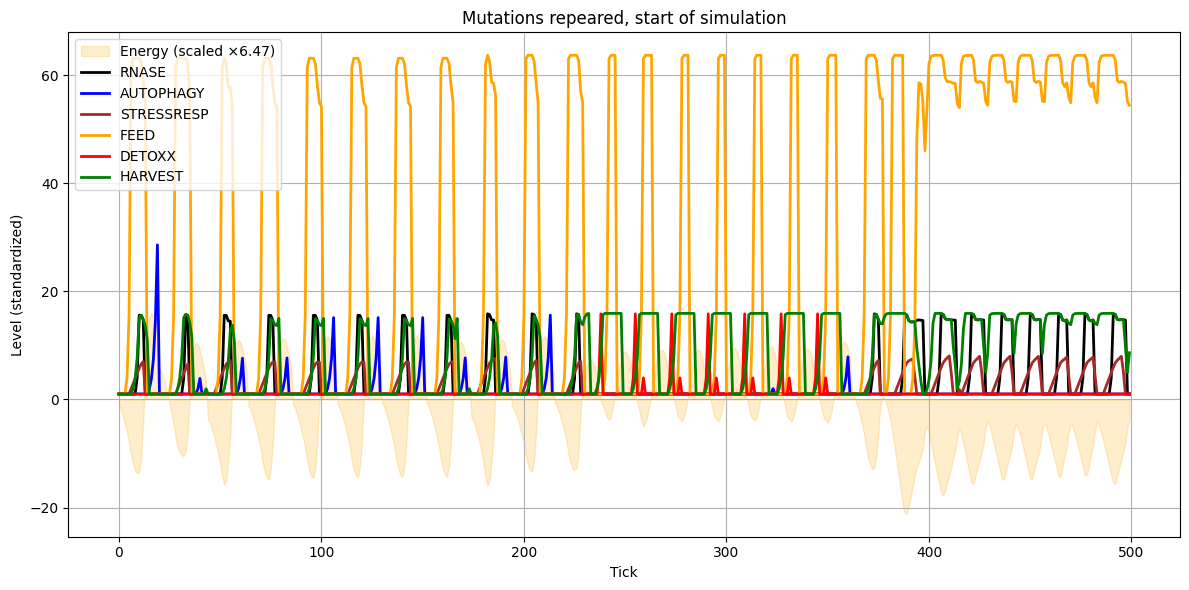

In [6]:
plot_gene_dynamics(df.iloc[:500,:], title="Mutations repeared, start of simulation",
                   cell_count=False,
                   genes={"RNASE": "black",
                          "AUTOPHAGY": "blue", 
                          "STRESSRESP": "brown",
                          "FEED": "orange",
                          "DETOXX": "red",
                          "HARVEST": "green"})

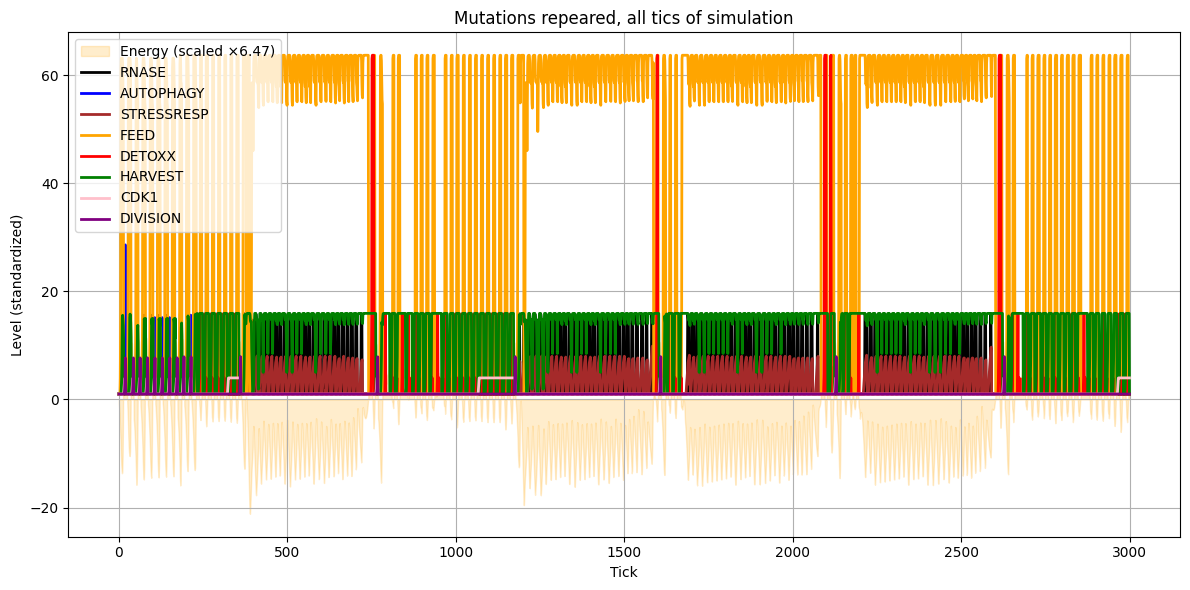

In [7]:
plot_gene_dynamics(df, title="Mutations repeared, all tics of simulation",
                   cell_count=False,
                   genes={"RNASE": "black",
                          "AUTOPHAGY": "blue", 
                          "STRESSRESP": "brown",
                          "FEED": "orange",
                          "DETOXX": "red",
                          "HARVEST": "green",
                          "CDK1": "pink",
                          "DIVISION": "purple"})

C:\Users\vsevo\AppData\Local\Temp\ipykernel_19276\189885138.py:89: RuntimeWarning: divide by zero encountered in log
  def to_scaled_cc(cc): return np.log(cc) * scale_cc


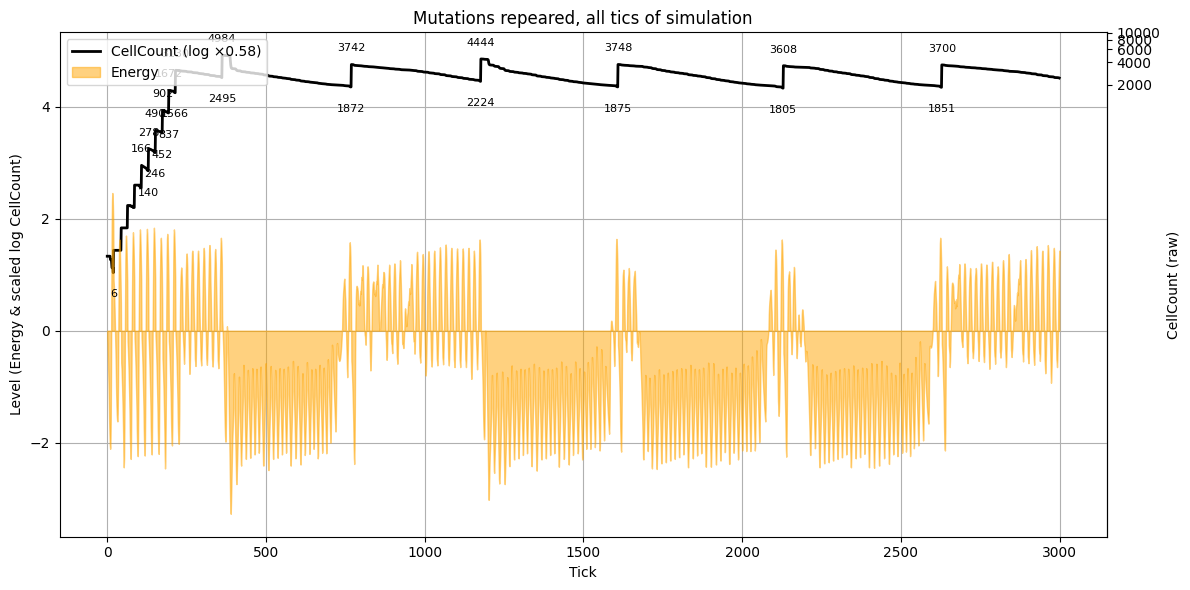

In [8]:
plot_gene_dynamics(df.iloc[:, :], title="Mutations repeared, all tics of simulation",
                   genes={})

In [9]:
# Stable genome
df, all_genes = run_simulation(
    ticks=3000,
    initial_food=-3,
    initial_energy=0,
    initial_cell_num=10000,
    support_cell_num=1000,
    energy_cost="default",
    mutation_chance=0.0001,
    protein_stability=0.7,
    cellular_products={
        "Wastetoxin":  ("energy",  0.005),   # 0.01 * energy, spent for TPM
        "CytokineX":   ("TPMsum",  0.0001),  # 0.0001 * sum of cell's TPM
        "FooMol":      ("FOODSENS", 0.001),  # 0.001 * TPM of FOODSENS gene (only when FOODSENS active)
        "CellProduct": ("CELLPROD", 0.03),   # 0.03 * TPM of CELLPROD gene (only when CELLPROD active)
    },
    toxins={
        "Energotoxin": (-2, ("energy", 0.2)), 
        "RNAtoxin":    (-2, ("TPM", 0.1)),
        "Wastetoxin":  (-3, ("common", 0.001)),
        "CytokineX":   (-3, ("energy",  0.001)),
        "CellProduct": (-3, ("energy", 0.001))
    },
    receptors={
        "ENGSENS":   (12, "qual", "st", "av", 50, ["DIVISION == 'inactive'"], ["DIVISION == 'active'"], False),
        "FOODSENS":  (4,  "qual", "av", "av", 50, ["Energy <= 1", "KINFEED == 'active'"], ["Energy >= 2", "DIVISION == 'active'"], False),
        "TOXSENS":  (2,  "qual", "wk", "wk", 50, ["DIVISION == 'inactive'"], ["Toxin < -2.9", "DIVISION == 'active'"], ("toxsens", 0.01)),
        "TOXNONSENS":  (2,  "qual", "wk", "av", 50, ["Energy <= -1"], ["DETOXX == 'active'", "DIVISION == 'active'"], ("toxsens", 0.1)),
        "MUTSENS":    (2, "qual", "st", "av", 50, ["ENGSENS == 'active'"], ["DIVISION == 'active'"], ("mutsens", 0.1)),
        "STRESSRESP": (2,  "qual", "wk", "av", 50, ["Energy <= -1", "DIVISION == 'inactive'"], ["Energy >= -1", "CDK1 == 'active'", "DIVISION == 'active'"], ("energy", 0.002)),
        "FUNACTIV":   (4,  "qual", "av", "av", 50, ["Energy >= 0"], ["Energy < 0", "KINSTRESS == 'active'", "DIVISION == 'active'"], False),
    },
    metabolism={
        "HARVEST":   (2,  "quan", "av", "av", 50, ["Energy <= 1", "FOODSENS == 'active'"], ["Energy >= 1", "DIVISION == 'active'"], ("energy", 0.005)),
        "FEED":    (2,  "quan", "st", "st", 70, ["Energy <= 0", "KINFEED == 'active'"], ["Energy >= 0", "Energy <= -2.99", "DIVISION == 'active'"], ("energy", 0.0015)),
        "SAFEED":    (2,  "quan", "av", "st", 150, ["Energy <= -1.5"], ["Energy >= -1.5", "DIVISION == 'active'"], ("energy", 0.005)),
        "RNASE":  (2,  "quan", "st", "av", 150, ["KINSTRESS == 'active'"], ["Energy >= -1.5", "DIVISION == 'active'"], ("RNAdigest", 0.015)),
        "AUTOPHAGY":    (4,  "quan", "av", "st", 100, ["Energy >= 1.5"], ["Energy <= 1.5", "DIVISION == 'active'"], ("process", 0.0005)),
        "DETOX":   (2,  "quan", "av", "av", 25, ["Toxin_detected == True"], ["DETOXX == 'active'", "DIVISION == 'active'"], ("detox", 0.01)),
        "DETOXX":   (2,  "quan", "st", "st", 15, ["Toxin_detected == True", "Toxin >= -1"], ["Toxin <= -2.5", "CDK1 == 'active'", "DIVISION == 'active'"], ("detox", 1)),
        "CELLPROD": (2,  "quan", "st", "st", 50, ["KINFUNK == 'active'"], ["Toxin > 1.5", "STRESSRESP == 'active'", "Energy <= -0.5", "DIVISION == 'active'"], False),
    },
    kinases={
        "KINFEED":     (3, "qual", "av", "wk", 50, ["Energy <= 1", "ENGSENS == 'active'"], ["Energy > 0.5", "DIVISION == 'active'"], False),
        "KINTOX":    (3, "qual", "av", "wk", 50, ["Toxin_detected == True"], ["Toxin_detected == False", "DIVISION == 'active'"], False),
        "KINSTRESS": (2, "qual", "st", "av", 150, ["STRESSRESP == 'active'"], ["Energy > -0.5", "KINSTRESS == 'active'", "DIVISION == 'active'"], False),
        "KINFUNK": (3, "qual", "av", "wk", 50, ["FUNACTIV == 'active'"], ["KINFUNK == 'active'", "STRESSRESP == 'active'", "DIVISION == 'active'"], False),
    },
    cell_cycle={
        "CDK1":      (2,  "qual", "wk", "wk", 50, ["Energy >= 1.5"], ["DIVISION == 'active'"], False),
    },
    division={
        "MUTGUARD":  (2, "qual", "st", "av", 50, ["DIVISION == 'inactive'"], ["DIVISION == 'active'"], ("mutrep", 0.01)),
        "DIVISION":  (6, "qual", "av", "av", 50, ["CDK1 == 'active'"], ["DIVISION == 'active'"], ("div", 1)),
    }
)
df.head(15)

,Food,Wastetoxin,CytokineX,FooMol,CellProduct,Energotoxin,RNAtoxin,Energy,CellCount,mut_detected,...,DETOXX,CELLPROD,KINFEED,KINTOX,KINSTRESS,KINFUNK,CDK1,MUTGUARD,DIVISION,Tick
0,-2.00,-2.997,-2.978,-3.000,-3.0,-2,-2,-0.11,9999,False,...,1.0,1.0,1.000000,1.000000,1.000000,1.0,1.0,3.945666,1.0,0
1,-1.00,-2.993,-2.949,-3.000,-3.0,-2,-2,-0.29,9998,False,...,1.0,1.0,1.000000,1.000000,1.000000,1.0,1.0,15.568278,1.0,1
2,0.00,-2.985,-2.896,-3.000,-3.0,-2,-2,-0.48,9997,False,...,1.0,1.0,1.972832,1.000000,1.000000,1.0,1.0,15.782655,1.0,2
3,1.00,-2.977,-2.838,-3.000,-3.0,-2,-2,-0.71,9995,False,...,1.0,1.0,3.892064,1.000000,1.000000,1.0,1.0,15.782648,1.0,3
4,2.00,-2.967,-2.766,-3.000,-3.0,-2,-2,-0.96,9992,False,...,1.0,1.0,3.945660,1.000000,1.000000,1.0,1.0,15.782640,1.0,4
5,2.96,-2.956,-2.690,-3.000,-3.0,-2,-2,-1.23,9986,False,...,1.0,1.0,3.945658,1.000000,1.000000,1.0,1.0,15.782631,1.0,5
6,2.76,-2.943,-2.600,-3.000,-3.0,-2,-2,-1.61,9975,False,...,1.0,1.0,3.945655,1.000000,1.000000,1.0,1.0,15.782620,1.0,6
7,1.96,-2.923,-2.459,-2.923,-3.0,-2,-2,-1.86,9955,False,...,1.0,1.0,3.945651,1.000000,1.000000,1.0,1.0,15.782603,1.0,7
8,1.38,-2.901,-2.306,-2.773,-3.0,-2,-2,-2.04,9923,False,...,1.0,1.0,3.945646,1.000000,3.945646,1.0,1.0,15.782584,1.0,8
9,0.16,-2.878,-2.143,-2.616,-3.0,-2,-2,-2.16,9882,False,...,1.0,1.0,3.945641,1.000000,1.000000,1.0,1.0,15.782564,1.0,9


In [10]:
df.tail(5)

,Food,Wastetoxin,CytokineX,FooMol,CellProduct,Energotoxin,RNAtoxin,Energy,CellCount,mut_detected,...,DETOXX,CELLPROD,KINFEED,KINTOX,KINSTRESS,KINFUNK,CDK1,MUTGUARD,DIVISION,Tick
2995,-3.0,-2.990,-2.930,90.505,-3.0,-3,-3,-1.57,3902,False,...,1.0,1.0,3.732050,1.0,1.000000,1.0,1.0,14.678692,1.0,2995
2996,-3.0,-2.990,-2.928,90.509,-3.0,-3,-3,-1.39,3900,False,...,1.0,1.0,3.716800,1.0,1.000000,1.0,1.0,14.602339,1.0,2996
2997,-3.0,-2.990,-2.932,90.513,-3.0,-3,-3,-0.92,3899,False,...,1.0,1.0,3.520428,1.0,3.520428,1.0,1.0,13.619153,1.0,2997
2998,-3.0,-2.995,-2.962,90.517,-3.0,-3,-3,-0.69,3898,False,...,1.0,1.0,3.472006,1.0,1.000000,1.0,1.0,13.376716,1.0,2998
2999,-3.0,-2.989,-2.924,90.522,-3.0,-3,-3,-0.81,3897,False,...,1.0,1.0,3.904842,1.0,1.000000,1.0,1.0,15.543820,1.0,2999


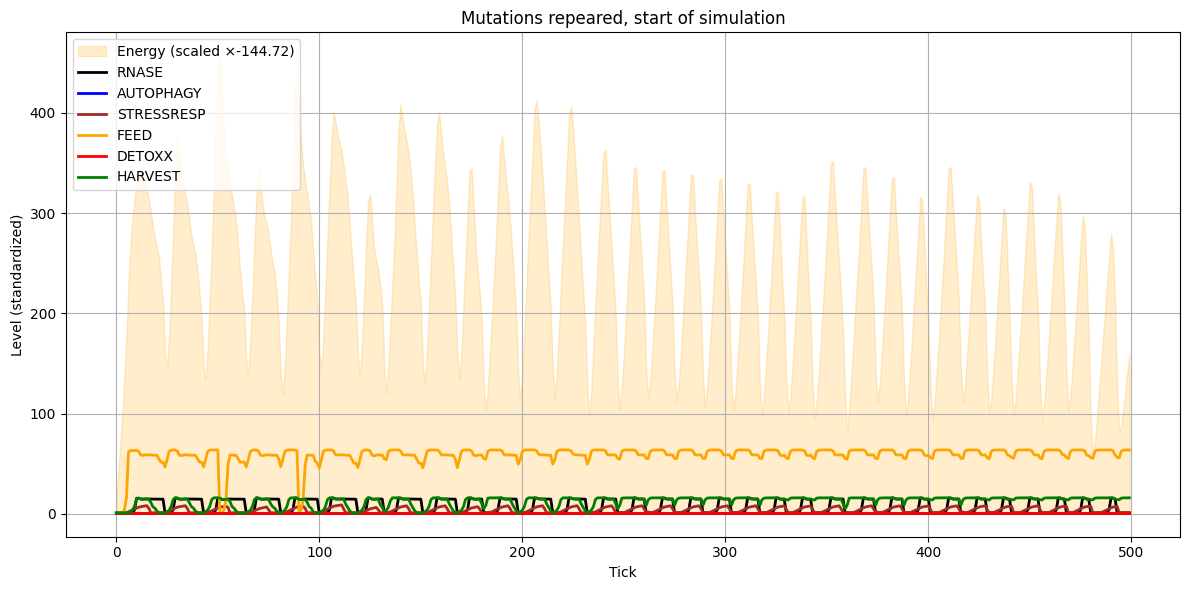

In [11]:
plot_gene_dynamics(df.iloc[:500,:], title="Mutations repeared, start of simulation",
                   cell_count=False,
                   genes={"RNASE": "black",
                          "AUTOPHAGY": "blue", 
                          "STRESSRESP": "brown",
                          "FEED": "orange",
                          "DETOXX": "red",
                          "HARVEST": "green"})

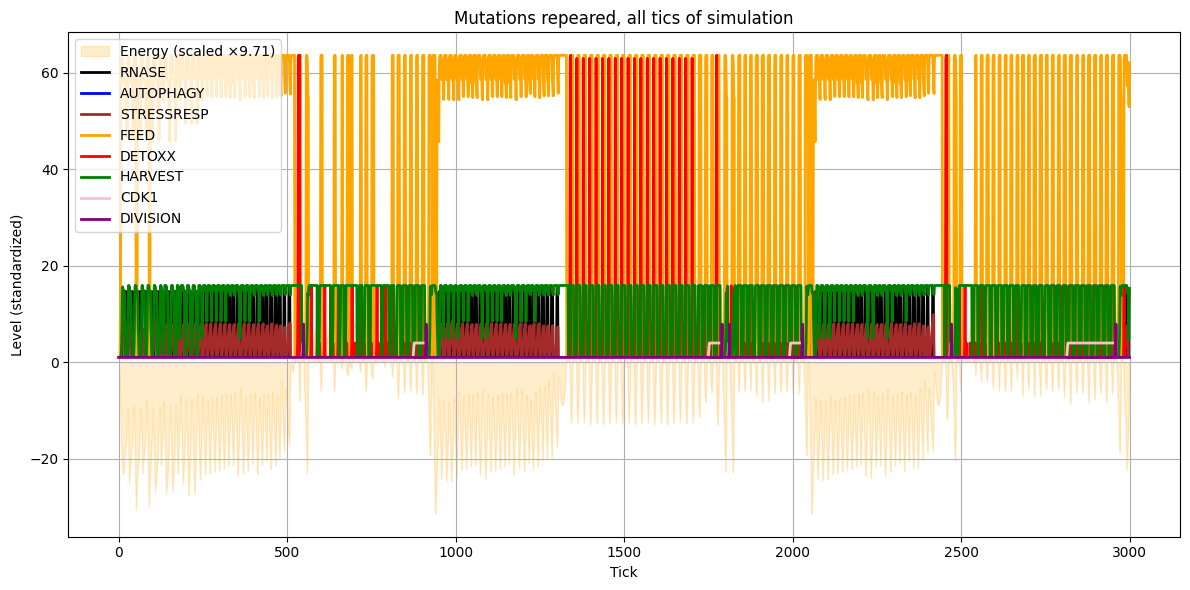

In [12]:
plot_gene_dynamics(df, title="Mutations repeared, all tics of simulation",
                   cell_count=False,
                   genes={"RNASE": "black",
                          "AUTOPHAGY": "blue", 
                          "STRESSRESP": "brown",
                          "FEED": "orange",
                          "DETOXX": "red",
                          "HARVEST": "green",
                          "CDK1": "pink",
                          "DIVISION": "purple"})

C:\Users\vsevo\AppData\Local\Temp\ipykernel_19276\189885138.py:89: RuntimeWarning: divide by zero encountered in log
  def to_scaled_cc(cc): return np.log(cc) * scale_cc


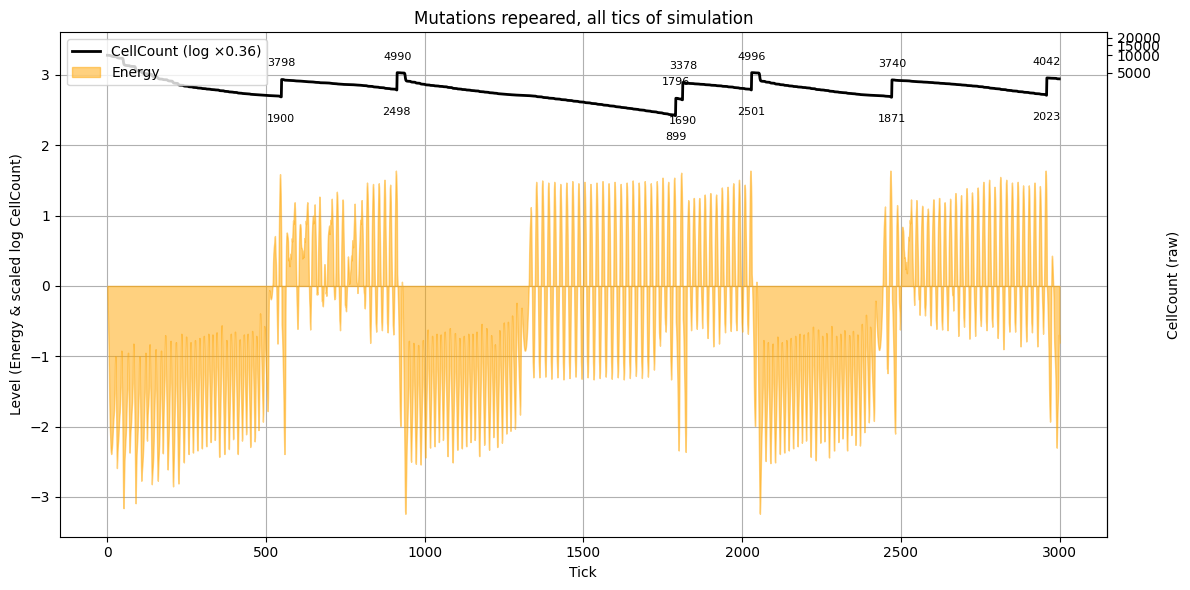

In [13]:
plot_gene_dynamics(df.iloc[:, :], title="Mutations repeared, all tics of simulation",
                   genes={})

In [14]:
# ZOMBIE cell! No energy is wasted at all
df, all_genes = run_simulation(
    ticks=1000,
    initial_food=-3,
    initial_energy=0,
    initial_cell_num=1000,
    support_cell_num=1000,
    energy_cost=0,
    mutation_chance=0.0001,
    protein_stability=0.7,
    cellular_products={
        "Wastetoxin":  ("energy",  0.005),   # 0.01 * energy, spent for TPM
        "CytokineX":   ("TPMsum",  0.0001),  # 0.0001 * sum of cell's TPM
        "FooMol":      ("FOODSENS", 0.001),  # 0.001 * TPM of FOODSENS gene (only when FOODSENS active)
        "CellProduct": ("CELLPROD", 0.03),   # 0.03 * TPM of CELLPROD gene (only when CELLPROD active)
    },
    toxins={
        "Energotoxin": (-2, ("energy", 0.2)), 
        "RNAtoxin":    (-2, ("TPM", 0.1)),
        "Wastetoxin":  (-3, ("common", 0.001)),
        "CytokineX":   (-3, ("energy",  0.001)),
        "CellProduct": (-3, ("energy", 0.001))
    },
    receptors={
        "ENGSENS":   (12, "qual", "st", "av", 50, ["DIVISION == 'inactive'"], ["DIVISION == 'active'"], False),
        "FOODSENS":  (4,  "qual", "av", "av", 50, ["Energy <= 1", "KINFEED == 'active'"], ["Energy >= 2", "DIVISION == 'active'"], False),
        "TOXSENS":  (2,  "qual", "wk", "wk", 50, ["DIVISION == 'inactive'"], ["Toxin < -2.9", "DIVISION == 'active'"], ("toxsens", 0.01)),
        "TOXNONSENS":  (2,  "qual", "wk", "av", 50, ["Energy <= -1"], ["DETOXX == 'active'", "DIVISION == 'active'"], ("toxsens", 0.1)),
        "MUTSENS":    (2, "qual", "st", "av", 50, ["ENGSENS == 'active'"], ["DIVISION == 'active'"], ("mutsens", 0.1)),
        "STRESSRESP": (5,  "qual", "wk", "av", 50, ["Energy <= -1", "DIVISION == 'inactive'"], ["Energy >= -1", "CDK1 == 'active'", "DIVISION == 'active'"], ("energy", 0.002)),
        "FUNACTIV":   (4,  "qual", "av", "av", 50, ["Energy >= 0"], ["Energy < 0", "KINSTRESS == 'active'", "DIVISION == 'active'"], False),
    },
    metabolism={
        "HARVEST":   (2,  "quan", "av", "av", 50, ["Energy <= 1", "FOODSENS == 'active'"], ["Energy >= 1", "Energy <= -2.99", "DIVISION == 'active'"], ("energy", 0.005)),
        "FEED":    (2,  "quan", "st", "st", 70, ["Energy <= 0", "KINFEED == 'active'"], ["Energy >= 0", "Energy <= -2.99", "DIVISION == 'active'"], ("energy", 0.0015)),
        "SAFEED":    (2,  "quan", "av", "st", 130, ["Energy <= -1", "KINFEED == 'active'"], ["Energy >= -1", "Energy <= -2.99", "DIVISION == 'active'"], ("energy", 0.0015)),
        "AUTOPHAGY":  (2,  "quan", "av", "av", 90, ["STRESSRESP == 'active'"], ["Energy >= -1", "DIVISION == 'active'"], ("process", 0.003)),
        "PROTREP":    (4,  "quan", "av", "av", 50, ["AUTOPHAGY == 'active'", "Energy <= -1.5"], ["Energy >= 0.5", "DIVISION == 'active'"], ("process", 0.005)),
        "DETOX":   (2,  "quan", "av", "av", 25, ["Toxin_detected == True"], ["DETOXX == 'active'", "DIVISION == 'active'"], ("detox", 0.01)),
        "DETOXX":   (2,  "quan", "st", "st", 15, ["Toxin_detected == True", "Toxin >= -1"], ["Toxin <= -2.5", "CDK1 == 'active'", "DIVISION == 'active'"], ("detox", 1)),
        "CELLPROD": (2,  "quan", "st", "st", 50, ["KINFUNK == 'active'"], ["Toxin > 1.5", "STRESSRESP == 'active'", "Energy <= -0.5", "DIVISION == 'active'"], False),
    },
    kinases={
        "KINFEED":     (3, "qual", "av", "wk", 50, ["Energy <= 1", "ENGSENS == 'active'"], ["Energy > 0.5", "DIVISION == 'active'"], False),
        "KINTOX":    (3, "qual", "av", "wk", 50, ["Toxin_detected == True"], ["Toxin_detected == False", "DIVISION == 'active'"], False),
        "KINSTRESS": (3, "qual", "av", "wk", 50, ["STRESSRESP == 'active'"], ["Energy > 0", "DIVISION == 'active'"], False),
        "KINFUNK": (3, "qual", "av", "wk", 50, ["FUNACTIV == 'active'"], ["KINFUNK == 'active'", "STRESSRESP == 'active'", "DIVISION == 'active'"], False),
    },
    cell_cycle={
        "CDK1":      (2,  "qual", "wk", "wk", 50, ["Energy >= 1"], ["DIVISION == 'active'"], False),
    },
    division={
        "MUTGUARD":  (2, "qual", "st", "av", 50, ["DIVISION == 'inactive'"], ["DIVISION == 'active'"], ("mutrep", 0.01)),
        "DIVISION":  (6, "qual", "av", "av", 50, ["CDK1 == 'active'"], ["DIVISION == 'active'"], ("div", 1)),
    }
)
df.head(15)

,Food,Wastetoxin,CytokineX,FooMol,CellProduct,Energotoxin,RNAtoxin,Energy,CellCount,mut_detected,...,DETOXX,CELLPROD,KINFEED,KINTOX,KINSTRESS,KINFUNK,CDK1,MUTGUARD,DIVISION,Tick
0,-2.00,-3.0,-2.998,-3.000,-3.000,-2,-2,-0.03,999,False,...,1.0,1.000000,1.000000,1.0,1,1.000000,1.000000,3.945667,1.0,0
1,-1.00,-3.0,-2.995,-3.000,-3.000,-2,-2,-0.05,998,False,...,1.0,1.000000,1.000000,1.0,1,1.000000,1.000000,15.568286,1.0,1
2,0.00,-3.0,-2.990,-3.000,-3.000,-2,-2,-0.08,997,False,...,1.0,1.000000,1.972833,1.0,1,1.000000,1.000000,15.782667,1.0,2
3,1.00,-3.0,-2.984,-3.000,-3.000,-2,-2,-0.11,996,False,...,1.0,1.000000,3.892072,1.0,1,1.000000,1.000000,15.782667,1.0,3
4,2.00,-3.0,-2.977,-3.000,-3.000,-2,-2,-0.14,995,False,...,1.0,1.000000,3.945667,1.0,1,1.000000,1.000000,15.782667,1.0,4
5,3.00,-3.0,-2.969,-3.000,-3.000,-2,-2,-0.15,994,False,...,1.0,1.000000,3.945667,1.0,1,1.000000,1.000000,15.782667,1.0,5
6,2.98,-3.0,-2.960,-3.000,-3.000,-2,-2,-0.13,993,False,...,1.0,1.000000,3.945667,1.0,1,1.000000,1.000000,15.782667,1.0,6
7,2.90,-3.0,-2.946,-2.992,-3.000,-2,-2,0.05,992,False,...,1.0,1.000000,3.945667,1.0,1,1.000000,1.000000,15.782667,1.0,7
8,2.85,-3.0,-2.931,-2.977,-3.000,-2,-2,0.33,991,False,...,1.0,1.000000,3.945667,1.0,1,1.000000,1.000000,15.782667,1.0,8
9,2.90,-3.0,-2.922,-2.962,-3.000,-2,-2,0.51,990,False,...,1.0,1.000000,3.945667,1.0,1,1.000000,1.000000,15.782667,1.0,9


In [15]:
df.tail(5)

,Food,Wastetoxin,CytokineX,FooMol,CellProduct,Energotoxin,RNAtoxin,Energy,CellCount,mut_detected,...,DETOXX,CELLPROD,KINFEED,KINTOX,KINSTRESS,KINFUNK,CDK1,MUTGUARD,DIVISION,Tick
995,-3.0,-3.0,1.340896e+09,3.685753e+10,-3.0,-3,-3,0.71,72037858867472,False,...,63.678176,1.0,1.0,3.979886,1,1.000000,1.000000,15.919544,1.0,995
996,-3.0,-3.0,1.297800e+09,3.800434e+10,-3.0,-3,-3,0.82,72014377235223,False,...,63.678176,1.0,1.0,3.979886,1,1.000000,1.000000,15.919544,1.0,996
997,-3.0,-3.0,1.297377e+09,3.915078e+10,-3.0,-3,-3,0.94,71980806844359,False,...,63.678176,1.0,1.0,3.979886,1,1.989943,1.000000,15.919544,1.0,997
998,-3.0,-3.0,1.303897e+09,4.029668e+10,-3.0,-3,-3,1.06,71932655021189,False,...,63.678176,1.0,1.0,3.979886,1,3.959873,1.000000,15.919544,1.0,998
999,-3.0,-3.0,1.317195e+09,4.144181e+10,-3.0,-3,-3,1.18,71863445607396,False,...,63.678176,1.0,1.0,3.979886,1,1.000000,1.989943,15.919544,1.0,999


C:\Users\vsevo\AppData\Local\Temp\ipykernel_19276\189885138.py:89: RuntimeWarning: divide by zero encountered in log
  def to_scaled_cc(cc): return np.log(cc) * scale_cc


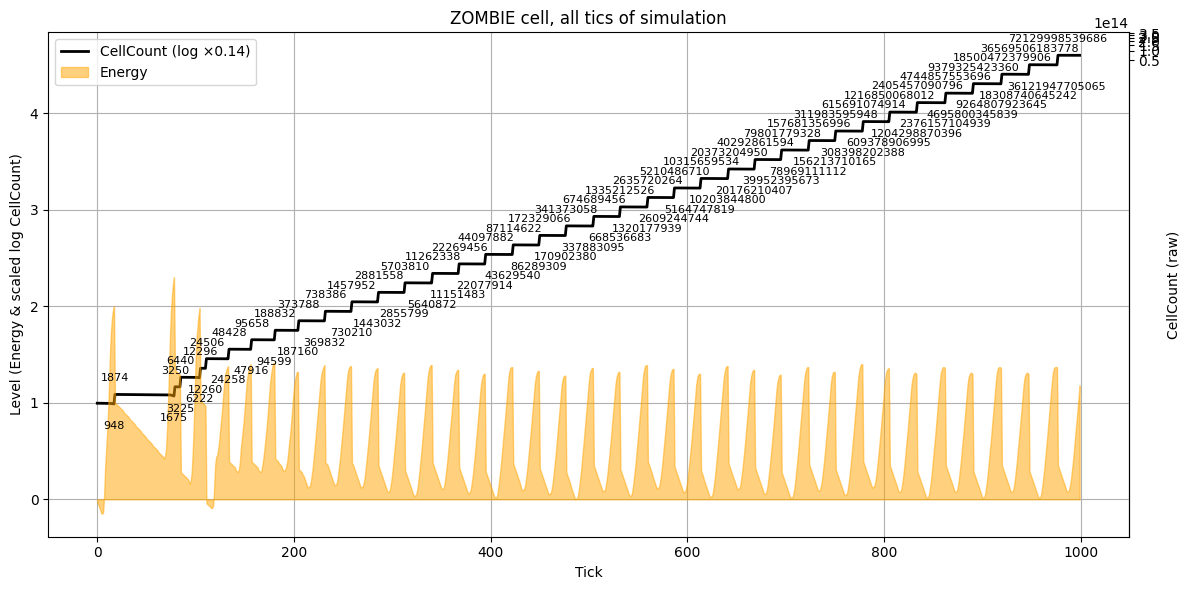

In [16]:
plot_gene_dynamics(df.iloc[:, :], title="ZOMBIE cell, all tics of simulation",
                   genes={})